In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
import cv2
import sys
import math
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
import cv2
import os
import numpy as np
import cv2
import sys
sys.setrecursionlimit(25000)
plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
'''
save a square image using lat long as center
image_path: path of the image
lat: latittude
long: longitude
square_width: size of squares edge
'''
def interest_area(image_path, lat, long, square_width):
    #image_path = r'./data/talhao_101035/tci20201010.tif'
    with rs.open(image_path) as rs_img:

        crs_img = CRS.from_user_input(rs.crs.CRS(rs_img.crs))
        crs_WSG84 = CRS("WGS84")
        coord_transformer = Transformer.from_crs(crs_from=crs_WSG84, crs_to=crs_img)
        res = coord_transformer.transform(long, lat)

        x = res[0]
        y = res[1]

        x_factor = rs_img.width / (rs_img.bounds.right - rs_img.bounds.left)
        y_factor = rs_img.height / (rs_img.bounds.top - rs_img.bounds.bottom)

        x_proj = (x - rs_img.bounds.left) * x_factor
        y_proj = (rs_img.bounds.top - y ) * y_factor
        # recortando um quadrado usando a latlong indicada como ponto central
        win_interest = Window(col_off=x_proj - (square_width / 2),
                              row_off=y_proj - (square_width / 2),
                              width=square_width,
                              height=square_width)

        kwargs = rs_img.meta.copy()
        # mantendo os meta dados
        kwargs.update({
            'height': win_interest.height,
            'width': win_interest.width,
            'transform': rs.windows.transform(win_interest, rs_img.transform)})

        win_result = rs_img.read(window=win_interest)
        #show(win_result)


        with rs.open(os.path.split(image_path)[0] + "/interest_"+ os.path.split(image_path)[1], 'w', **kwargs) as dst:
            dst.write(rs_img.read(window=win_interest))

        print("")
    return win_result

In [3]:
# raw image
#img = cv2.imread("./data/talhao_101035/interest_b0420201015.tif", -1)
#img = cv2.imread("./data/talhao_103330/interest_b0420201217.tif", -1)
#img = cv2.imread("./data/talhao_100767/interest_b0420201015.tif", -1)
#img = cv2.imread("./data/talhao_102996/interest_b0420201013.tif", -1)
#img = cv2.imread("./data/talhao_102939/interest_b0420201105.tif", -1)
# image converted to 8bits
#img_8bits = cv2.convertScaleAbs(img, alpha=0.03)


#img_equalized = cv2.equalizeHist(img_8bits)
#img_blur = cv2.GaussianBlur(img_8bits, (5,5), 0 )
#img_lap = cv2.Laplacian(img_8bits, cv2.CV_64F)
#img_lap = np.uint8(np.absolute(img_lap))

#plt.imshow(img_8bits,cmap = 'gray')
#plt.show()

In [4]:
def get_8bits(img_source, show=False):    
    img_8bits = cv2.convertScaleAbs(img_source, alpha=0.03)
    if show:
        plt.imshow(img_8bits,cmap = 'gray')
        plt.show()
    return img_8bits

def get_edges(img_source, show=False):
    img_edges = cv2.Canny(img_source,10,50, None)
    if show:
        plt.imshow(img_edges,cmap = 'gray')
        plt.show()        
    return img_edges


def get_binary(img_source, show=False):
    img_blank = np.copy(img_source) * 0
    # make the image array a binary (0 background, 1 border)
    result = ""
    lines = len(img_blank)
    columns = len(img_blank[0])
    for line in range(lines):
        for column in range(columns):
            if img_source[line, column] > 0:
                img_blank[line, column] = 1
            else:
                img_blank[line, column] = 0
                
    if show:
        plt.imshow(img_blank,cmap = 'gray')
        plt.show() 
    return img_blank

# img_8bits_test = get_8bits(img, show=False)
# img_edges = get_edges(img_8bits_test, show=True)
# img_edges_binary = get_binary(img_edges, show=False) 

In [5]:
def get_hough_lines_p(img_source, 
                      rho,
                      theta,
                      threshold,
                      min_line_length,
                      max_line_gap,
                      stroke_size=5,
                      show=False):   
#     rho = 1  # distance resolution in pixels of the Hough grid
#     theta = np.pi / 180  # angular resolution in radians of the Hough grid
#     threshold = 15  # minimum number of votes (intersections in Hough grid cell)
#     min_line_length = 100  # minimum number of pixels making up a line
#     max_line_gap = 20

    img_copy = np.copy(img_source)
    img_blank = np.copy(img_source) * 0

    # maximum gap in pixels between connectable line segments
    lines_houghlinesp = cv2.HoughLinesP(img_copy, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

    for line in lines_houghlinesp:
        for x1,y1,x2,y2 in line:
            cv2.line(img_copy,(x1,y1),(x2,y2),(255,0,0),stroke_size)
            cv2.line(img_blank,(x1,y1),(x2,y2),(255,0,0),stroke_size)

    if show:
        # show image merged
        plt.imshow(img_blank)
        plt.show()

        # show only lines
        #plt.imshow(img_blank,cmap = 'gray')
        #plt.show()
    
    return img_blank


# hough_lines_p = get_hough_lines_p(img_edges, 
#                                   rho=1, theta=np.pi / 180, 
#                                   threshold=15,
#                                   min_line_length=100,
#                                   max_line_gap=20,
#                                   stroke_size=5,
#                                   show=True)

In [6]:
def get_hough_lines(img_source, 
                    rho, 
                    theta, 
                    threshold, 
                    line_length,
                    stroke_size=5,
                    show=False):    
    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 132  # minimum number of votes (intersections in Hough grid cell)

    img_copy = np.copy(img_source)
    img_blank = np.copy(img_source) * 0

    lines_houghlines = cv2.HoughLines(img_copy, rho, theta, threshold)


    for line in lines_houghlines:
        rho,theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + line_length*(-b))
        y1 = int(y0 + line_length*(a))
        x2 = int(x0 - line_length*(-b))
        y2 = int(y0 - line_length*(a))
        cv2.line(img_copy, (x1, y1), (x2, y2), (255, 0, 0), stroke_size)

    if show:
        # Draw the lines on the  image
        plt.imshow(img_copy)
        plt.show()
    return img_copy

# hough_lines = get_hough_lines(img_edges_binary, 
#                               rho=1, 
#                               theta=np.pi / 180, 
#                               threshold=132, 
#                               line_length=500,
#                               show=True) 


In [7]:
def print_grid(img_source, grid_size=100, show=False):
    img_grid = np.copy(img_source)
    img_grid = np.bitwise_not(img_grid) 
    height, width = img_grid.shape
    for x in range(0, width -1, grid_size):    
        cv2.line(img_grid, (x, 0), (x, height), (125,0,0), 1)

    for y in range(0, width -1, grid_size):
        cv2.line(img_grid, (0, y), (width, y), (125,0,0), 1)

    if show:
        plt.imshow(img_grid, cmap="gray")
        plt.show()
    return img_grid

# img_grid = print_grid(img_edges, grid_size=100, show=True)


In [8]:
def get_hough_lines_grid(img_source, 
                         rho,
                         theta,
                         threshold,
                         line_length,
                         grid_size=100,
                         stroke_size=5,
                         show=False):
    
    max_rho =  math.sqrt(2 * grid_size **2)
    img_grid = np.copy(img_source)

    height, width = img_grid.shape
    new_image2 = np.copy(img_grid)
    for line in range(0, height-1, grid_size):    
        for column in range(0, width -1, grid_size):
            cell = img_grid[line:line+grid_size-1, column:column+grid_size-1]    
            cell_copy = np.copy(cell)       
            clean_cell = np.zeros((grid_size-1,grid_size-1))
            lines = cv2.HoughLines(cell, rho, theta, threshold)
            if not lines is None:
                for y in lines:
                    _rho,_theta = y[0]
                    a = np.cos(_theta)
                    b = np.sin(_theta)
                    x0 = a*_rho
                    y0 = b*_rho
                    x1 = int(x0 + max_rho*(-b))
                    y1 = int(y0 + max_rho*(a))
                    x2 = int(x0 - max_rho*(-b))
                    y2 = int(y0 - max_rho*(a))
                    cv2.line(clean_cell, (x1, y1), (x2, y2), (255,0,0), stroke_size)
                    cv2.line(cell_copy, (x1, y1), (x2, y2), (255,0,0), stroke_size)

            new_image2[line:line+grid_size-1, column:column+grid_size-1] = cell_copy

    if show:
        plt.imshow(new_image2)
        plt.show() 
    return new_image2

# hough_lines_grid = get_hough_lines_grid(img_edges_binary, 
#                               rho=1,
#                               theta=np.pi / 180,
#                               threshold=50,
#                               line_length=1,
#                               grid_size=100,
#                               show=True) 

In [9]:
def get_eroded(img_source, show=False):
    # Creating kernel
    kernel = np.ones((3, 3), np.uint8)
  
    # Using cv2.erode() method 
    result = cv2.erode(img_source, kernel) 

    if show:
        plt.imshow(result)
    
    return result

In [10]:
def img_pipeline(img_source):
    img_8bits_test = get_8bits(img_source, show=False)
    img_edges = get_edges(img_8bits_test, show=True)
    img_edges_binary = get_binary(img_edges, show=False)
    
    stroke_size = 4
    grid_size=100
    
    hough_lines = get_hough_lines(img_edges_binary, 
                              rho=1, 
                              theta=np.pi / 180, 
                              threshold=132, 
                              line_length=500,
                              stroke_size=stroke_size,
                              show=True) 
    
    hough_lines_grid = get_hough_lines_grid(img_edges_binary, 
                              rho=1,
                              theta=np.pi / 180,
                              threshold=50,
                              line_length=1,
                              grid_size=grid_size,
                              stroke_size=stroke_size,
                              show=True) 
    
    hough_lines_p = get_hough_lines_p(img_edges, 
                                  rho=1, theta=np.pi / 180, 
                                  threshold=15,
                                  min_line_length=100,
                                  max_line_gap=20,
                                  stroke_size=stroke_size,
                                  show=True)
    
    eroded = get_eroded(hough_lines_p, show=True)


In [11]:
img_1 = cv2.imread("./data/talhao_101035/interest_b0420201015.tif", -1)
img_2 = cv2.imread("./data/talhao_103330/interest_b0420201217.tif", -1)
img_3 = cv2.imread("./data/talhao_100767/interest_b0420201015.tif", -1)
img_4 = cv2.imread("./data/talhao_102996/interest_b0420201013.tif", -1)
img_5 = cv2.imread("./data/talhao_102939/interest_b0420201105.tif", -1)

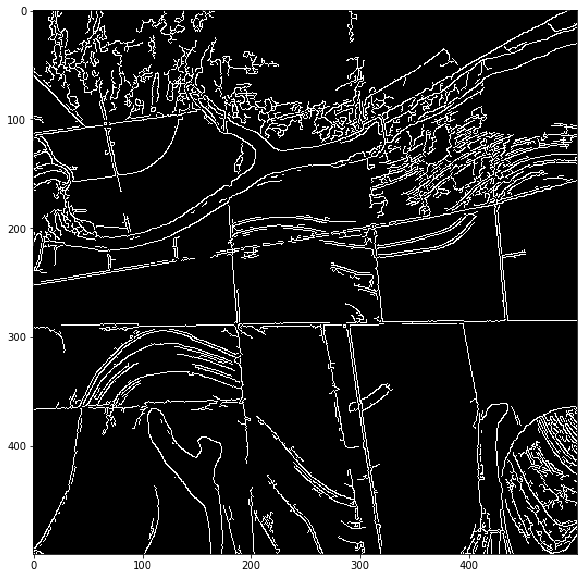

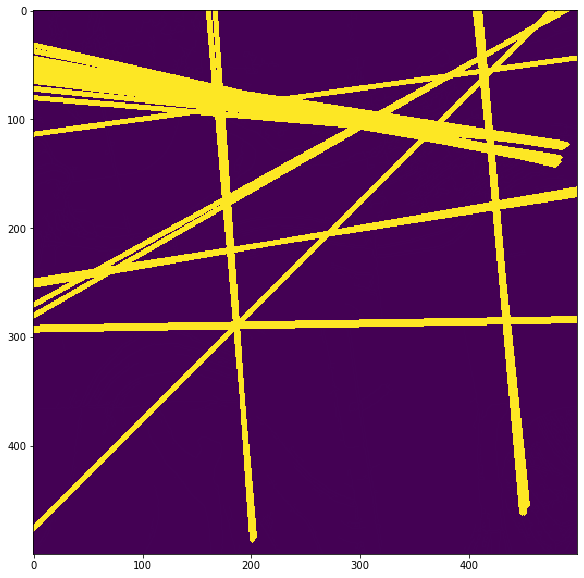

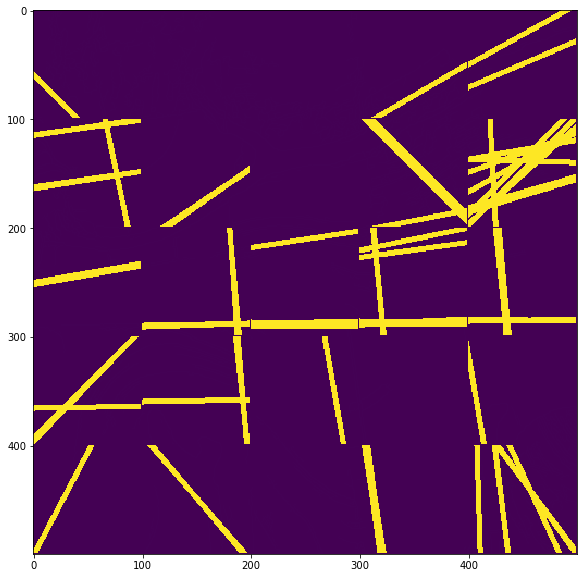

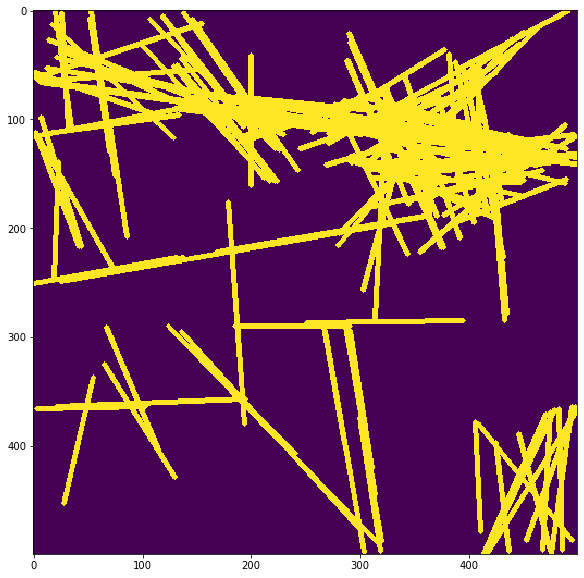

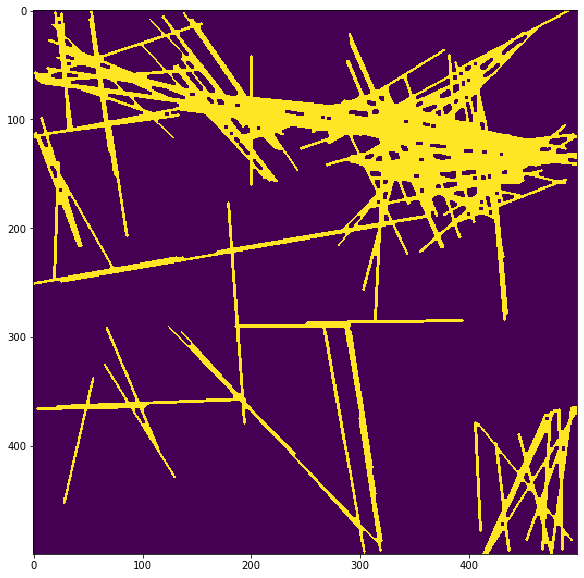

In [12]:
abc = img_pipeline(img_1)

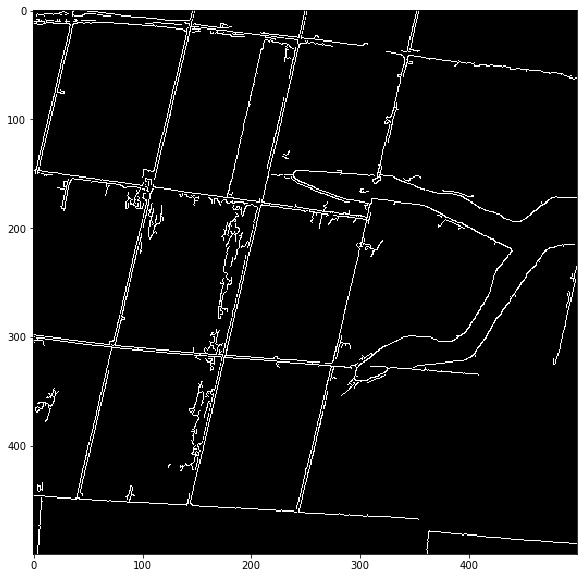

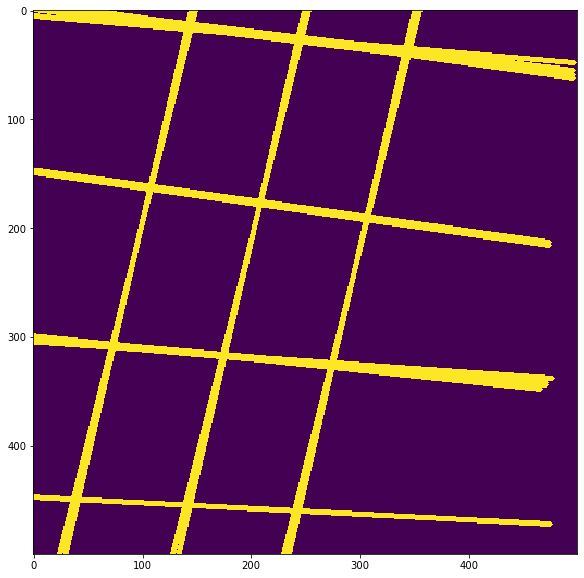

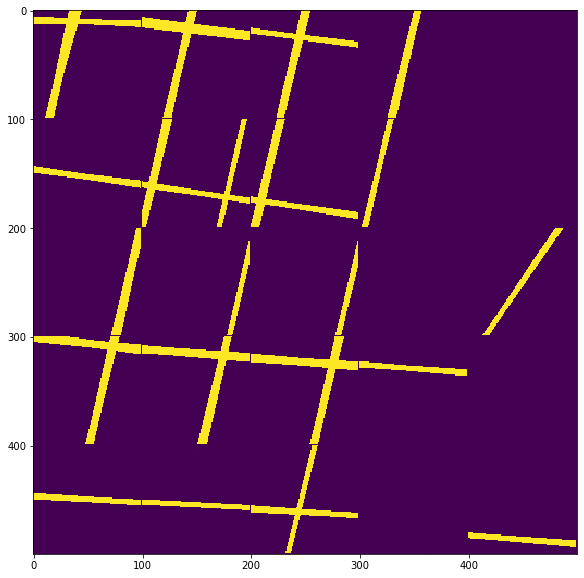

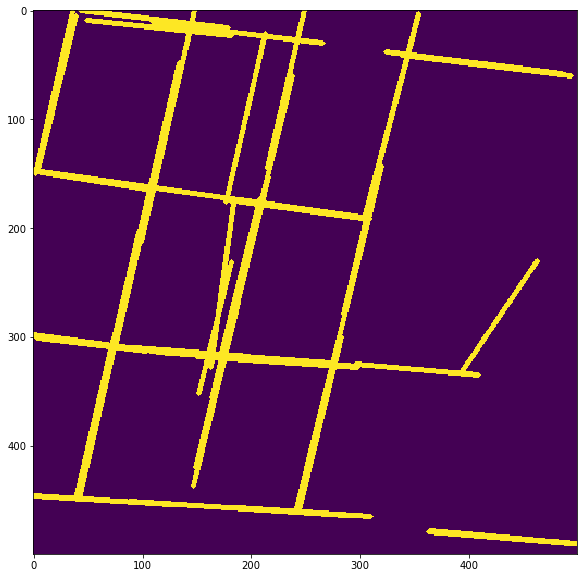

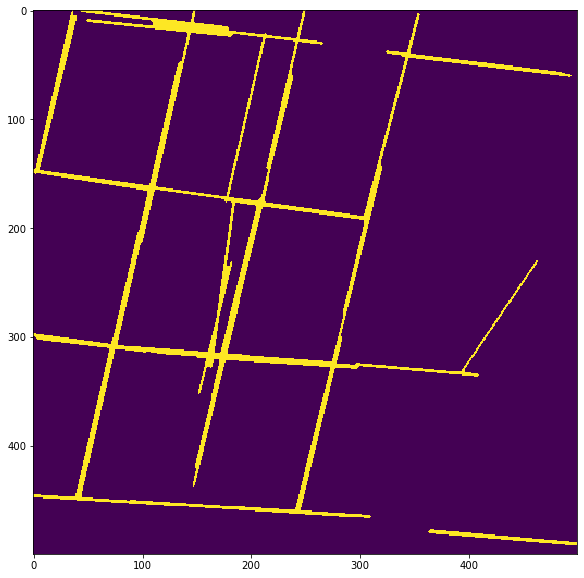

In [13]:
img_pipeline(img_2)

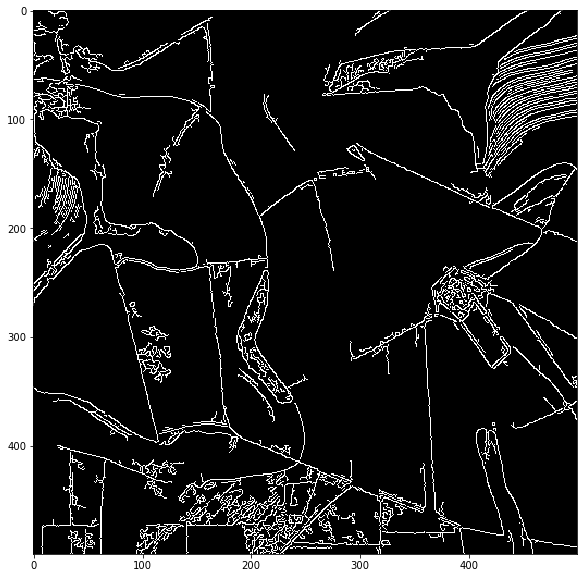

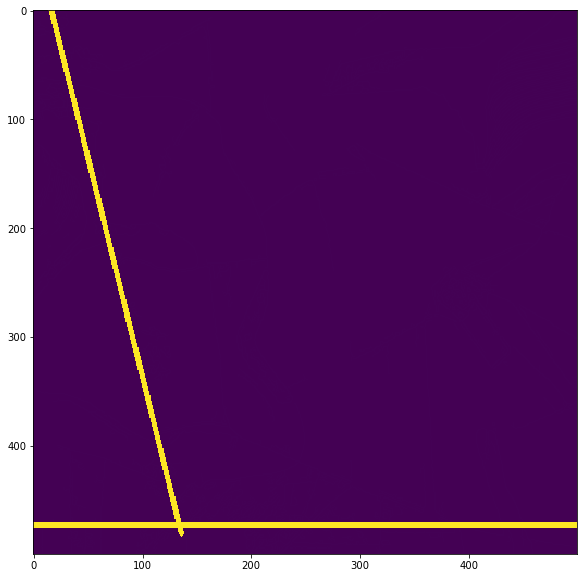

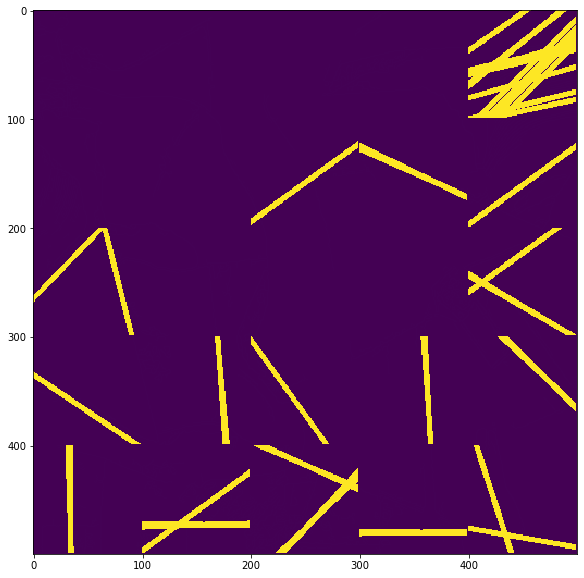

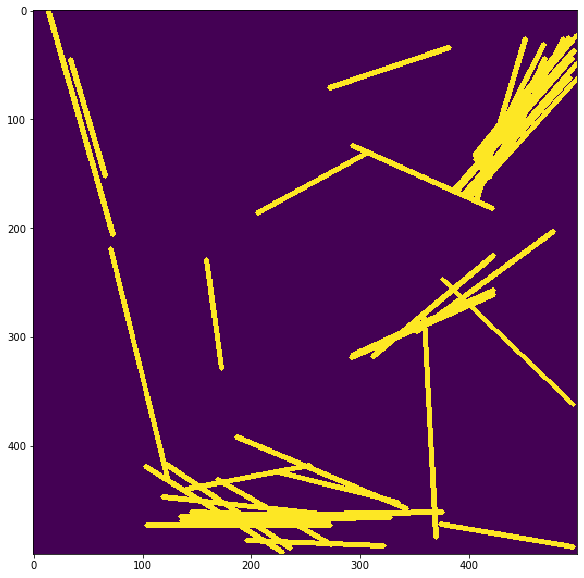

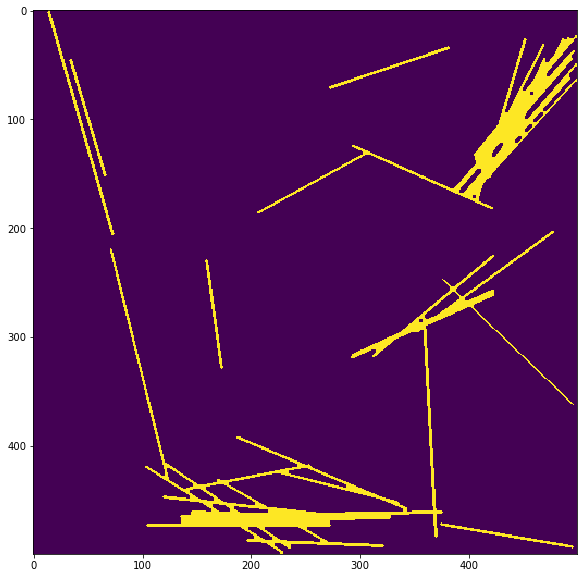

In [14]:
img_pipeline(img_3)

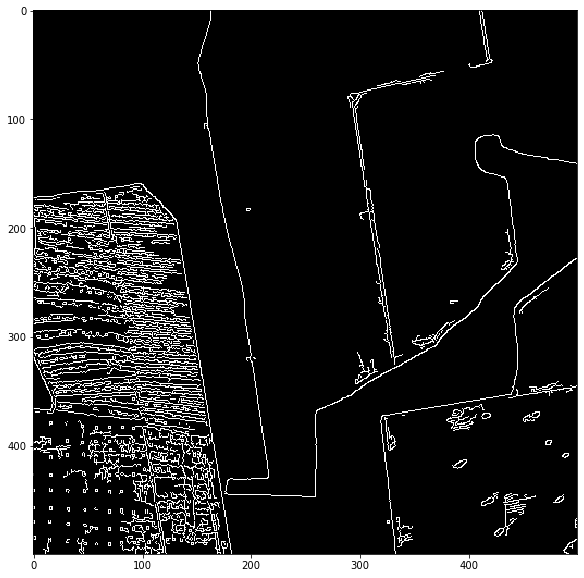

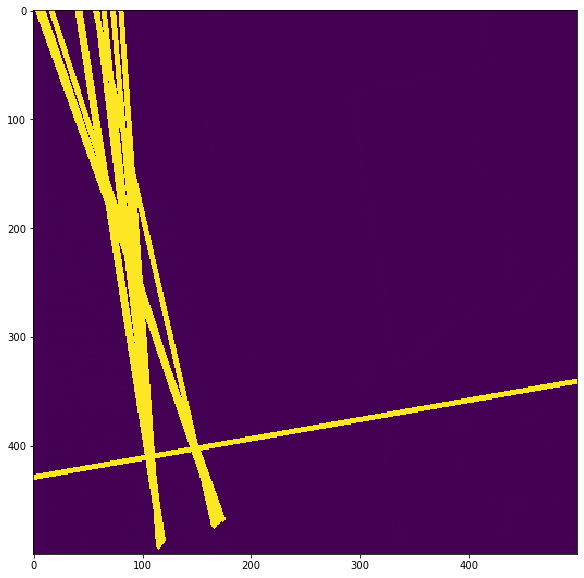

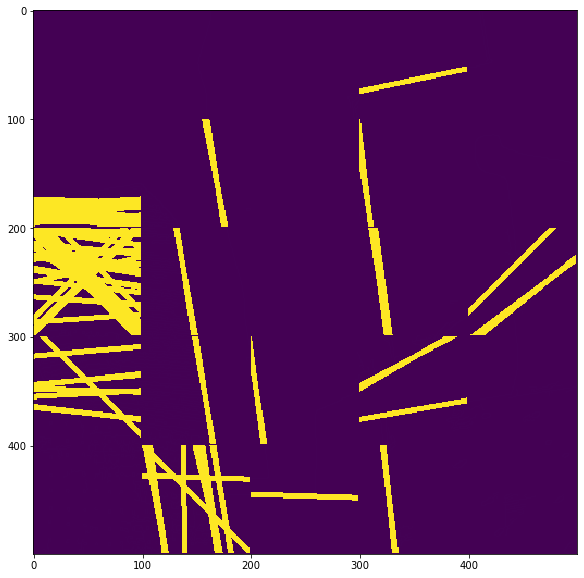

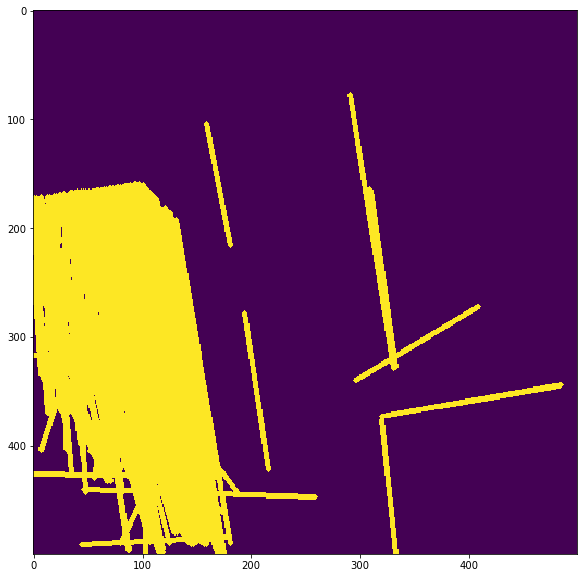

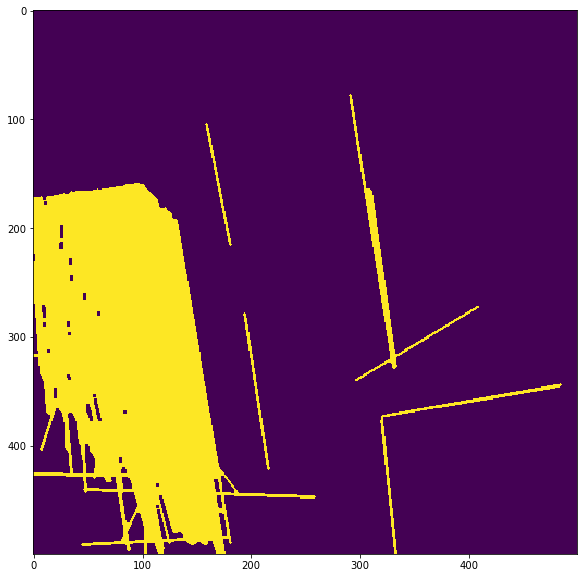

In [15]:
img_pipeline(img_4)

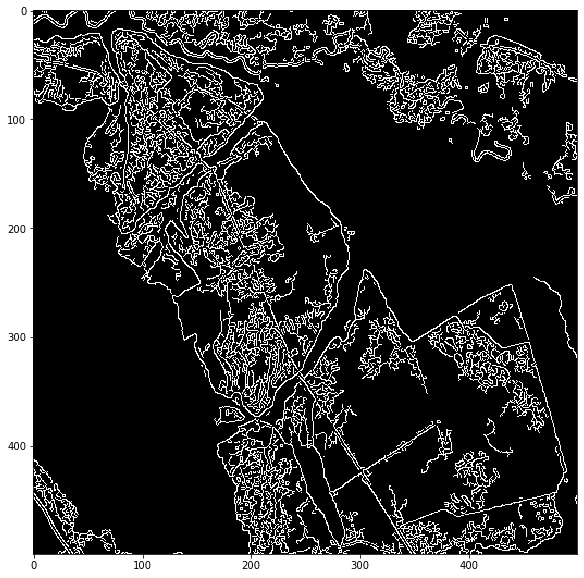

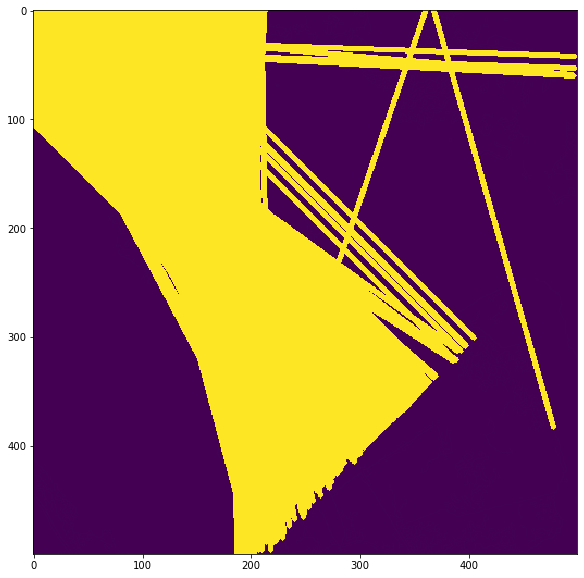

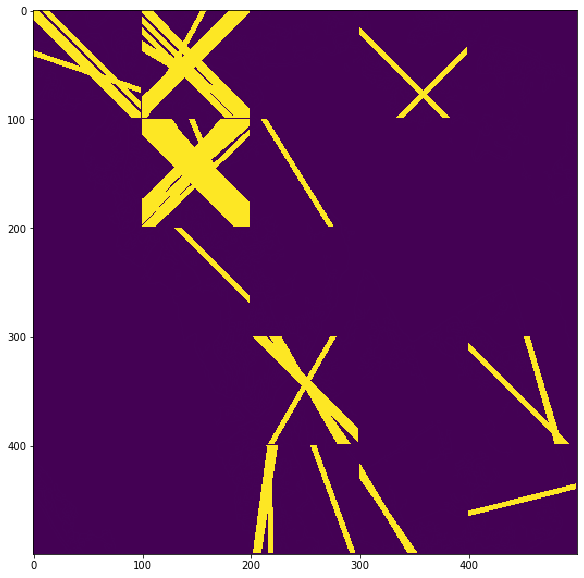

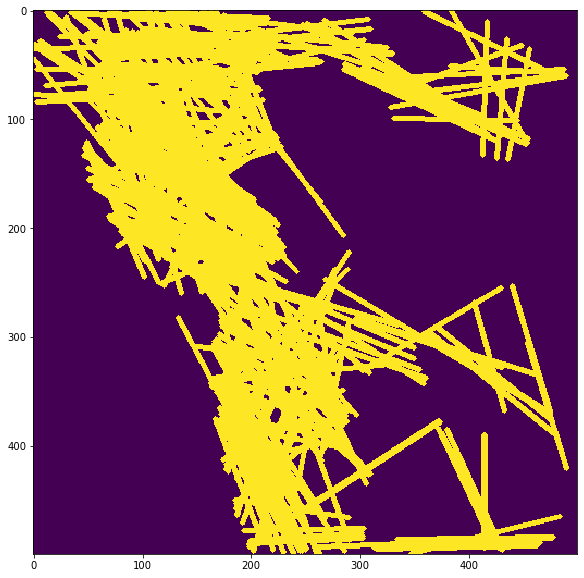

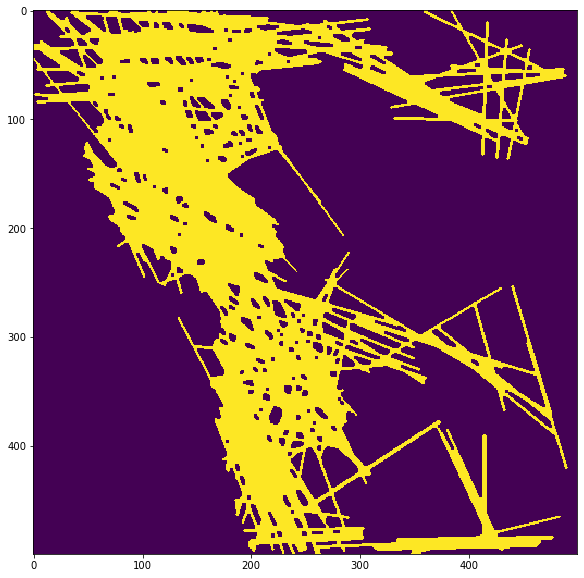

In [16]:
img_pipeline(img_5)

In [18]:
def find_object(seed, image_matrix, object_list):
    background_color = 255 # definiing background as white
    line_ini = seed[0] - 1
    line_end = line_ini + 3
    col_ini = seed[1] - 1
    col_end = col_ini + 3
    object_list[seed] = True
    for line in range(line_ini, line_end):
        for column in range(col_ini, col_end):
            if column != seed[1] or line != seed[0]:
                if (line, column) not in object_list.keys():
                    if image_matrix[line][column] < background_color:
                        find_object((line, column), image_matrix, object_list)

    return object_list